# Network interpretability of lung X-rays

In this tutorial, we demonstrate visualising network interpretability through a classification task.

The data are a set of X-rays collated from a variety of sources. The labels used are:
- normal (the absence of the following classes)
- pneumonia
- covid

We then use GradCam and occlusion sensitivity to interpret the trained network's classification choices.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/interpretability/covid_classification.ipynb)

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
import os
import zipfile
from tqdm import tqdm
from glob import glob
from enum import Enum
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

import monai
from monai.networks.utils import eval_mode
from monai.networks.nets import densenet121
from monai.transforms import (
    Compose, LoadImage, Lambda, AddChannel,
    ScaleIntensity, ToTensor, RandRotate,
    RandFlip, Rand2DElastic, RandZoom, Resize,
)

monai.config.print_config()
random_seed = 42
random.seed(random_seed)
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.4.0+62.g8fef0e1
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 8fef0e12b4b79aa124b9ba85f8dd8f452baad1cf

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 7.0.0
Tensorboard version: 2.2.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Download the data

The data is currently hosted on Kaggle:  
https://www.kaggle.com/ericspod/project-monai-2020-bootcamp-challenge-dataset

Unfortunately, there's no way to download this automatically, so you'll have to download it yourself and then point this notebook to look at the downloaded `zip` file.

In [3]:
data_path_zip = os.path.join(os.environ.get(
    "MONAI_DATA_DIRECTORY", "."), "archive.zip")
data_path = os.path.join(os.environ.get(
    "MONAI_DATA_DIRECTORY", "."), "covid_xray_combined_small")
if not os.path.isdir(data_path):
    if not os.path.isfile(data_path_zip):
        raise RuntimeError("TODO: Download needed.")
    with zipfile.ZipFile(data_path_zip, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            try:
                zf.extract(member, data_path)
            except zipfile.error:
                pass

# Load images

For ease, we'll only use the images in the training folder

In [4]:
crop_size = (320, 320)  # set size of images for network


class Diagnosis(Enum):
    normal = 0
    pneumonia = 1
    covid = 2


num_class = len(Diagnosis)


def get_label(path):
    fname = os.path.basename(path)
    if fname[:6] == "normal":
        return Diagnosis.normal.value
    elif fname[:9] == "pneumonia":
        return Diagnosis.pneumonia.value
    elif fname[:5] == "covid":
        return Diagnosis.covid.value
    else:
        raise RuntimeError(f"Unknown label: {path}")


class CovidImageDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms, even_balance=True):

        self.image_files = files
        self.labels = list(map(get_label, self.image_files))
        self.transforms = transforms
        # For even balance, find out which diagnosis has the fewest images
        # and then get that many of each diagnosis
        if even_balance:
            # fewest images of any diagnosis
            num_to_keep = min(self.labels.count(i.value) for i in Diagnosis)
            print(f"num to keep per class: {num_to_keep}")
            self.image_files = []
            for d in Diagnosis:
                files_for_diagnosis = \
                    [file for file in files if get_label(file) == d.value]
                self.image_files += files_for_diagnosis[:num_to_keep]
            random.shuffle(self.image_files)
            self.labels = list(map(get_label, self.image_files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim == 2 else im[..., 0]),
    AddChannel(),
    Resize(crop_size, "area"),
    ScaleIntensity(),

    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    Rand2DElastic((0.3, 0.3), (1.0, 2.0)),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim == 2 else im[..., 0]),
    AddChannel(),
    Resize(crop_size, "area"),
    ScaleIntensity(),
    ToTensor(),
])

training_data_path = os.path.join(data_path, "training_data", "training_data")
all_files = glob(os.path.join(training_data_path, "*.png"))
random.shuffle(all_files)
train_frac = 0.9
num_training_files = round(train_frac * len(all_files))
train_files = all_files[:num_training_files]
val_files = all_files[num_training_files:]

batch_size = 100

train_ds = CovidImageDataset(train_files, train_transforms, False)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=10)

val_ds = CovidImageDataset(val_files, val_transforms, False)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True, num_workers=10)

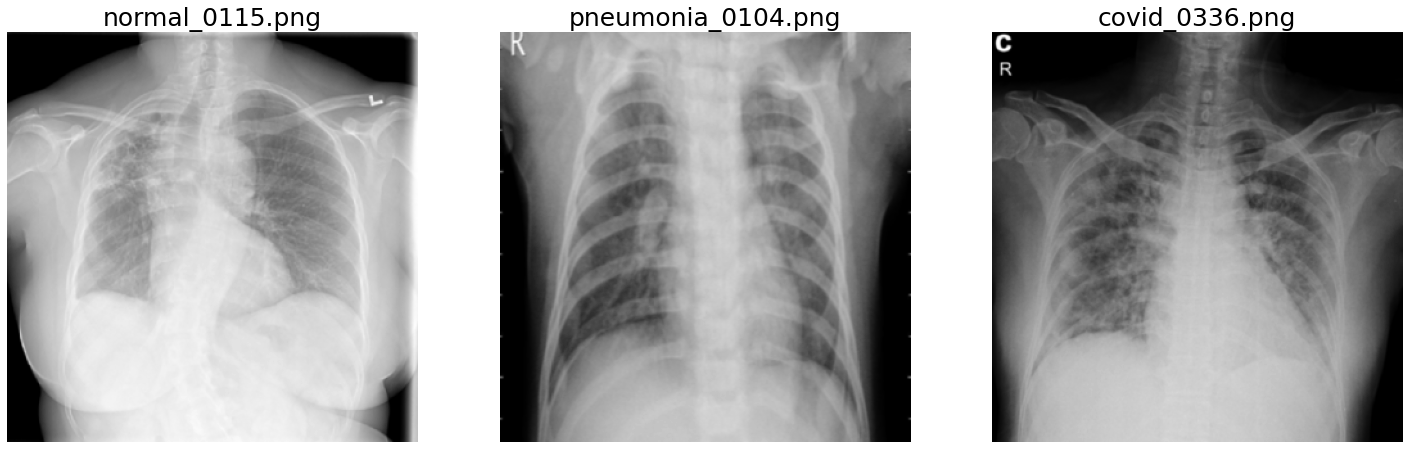

In [5]:
# Display examples
fig, axes = plt.subplots(1, 3, figsize=(25, 15), facecolor='white')
for true_label in Diagnosis:
    fnames = [v for v in val_files if true_label.name in os.path.basename(v)]
    random.shuffle(fnames)
    fname = fnames[0]
    im = val_transforms(fname)
    ax = axes[true_label.value]
    im_show = ax.imshow(im[0], cmap='gray')
    ax.set_title(os.path.basename(fname), fontsize=25)
    ax.axis('off')

# Training

In [6]:
def create_new_net():
    return densenet121(
        spatial_dims=2,
        in_channels=1,
        out_channels=num_class
    ).to(device)

<IPython.core.display.Javascript object>


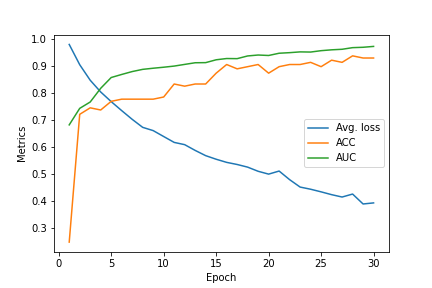

In [7]:
%matplotlib notebook

max_epochs = 30
val_interval = 1
lr = 1e-5
epoch_loss_values = []
auc = []
acc = []
best_acc = -1

net = create_new_net()
net = net.to(device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr)

# Plotting stuff
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(max_epochs):
    net.train()
    epoch_loss = 0

    for batch_data in train_loader:

        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        opt.zero_grad()
        outputs = net(inputs)
        lossval = loss(outputs, labels)
        lossval.backward()
        opt.step()

        epoch_loss += lossval.item()

    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(net):
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device),

                outputs = net(val_images)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            auc_metric = monai.metrics.compute_roc_auc(
                y_pred, y, to_onehot_y=True, softmax=True)
            auc.append(auc_metric)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            acc.append(acc_metric)

            if acc_metric > best_acc:
                best_acc = acc_metric
                torch.save(net.state_dict(),
                           "best_acc_lung_xray_densenet.pth")

    ax.clear()
    train_epochs = np.linspace(1, epoch + 1, epoch + 1)
    ax.plot(train_epochs, epoch_loss_values, label='Avg. loss')
    val_epochs = np.linspace(
        1, epoch + 1, np.floor(
            (epoch + 1) / val_interval).astype(np.int32))
    ax.plot(val_epochs, acc, label='ACC')
    ax.plot(val_epochs, auc, label='AUC')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metrics')
    ax.legend()
    fig.canvas.draw()

              precision    recall  f1-score   support

      normal       1.00      0.54      0.70        13
   pneumonia       0.89      0.94      0.92        18
       covid       0.94      0.99      0.96        94

    accuracy                           0.94       125
   macro avg       0.94      0.82      0.86       125
weighted avg       0.94      0.94      0.93       125



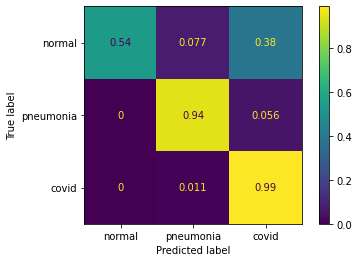

In [8]:
%matplotlib inline
# Load best model
net = create_new_net().to(device)
net.load_state_dict(torch.load("best_acc_lung_xray_densenet.pth"))
net.eval()

with eval_mode(net):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(
            device), val_data[1].to(device),

        outputs = net(val_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Interpretability

Use GradCAM and occlusion sensitivity for network interpretability.

The occlusion sensitivity returns two images: the sensitivity image and the most probable class.

* Sensitivity image -- how the probability of an inferred class changes as the corresponding part of the image is occluded.
    * Big decreases in the probability imply that that region was important in inferring the given class
    * The output is the same as the input, with an extra dimension of size N appended. Here, N is the number of inferred classes. To then see the sensitivity image of the class we're interested (maybe the true class, maybe the predcited class, maybe anything else), we simply do ``im[...,i]``.
* Most probable class -- if that part of the image is covered up, does the predicted class change, and if so, to what?

In this example the network has been sufficiently trained that the predicted class doesn't change as parts of the image are occluded. However, one can imagine how this feature might be useful when the results are less than satisfactory. 

In [10]:
# for name, _ in net.named_modules(): print(name)
target_layer = "class_layers.relu"

gradcam = monai.visualize.GradCAM(nn_module=net, target_layers=target_layer)
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=net, mask_size=10, n_batch=batch_size, stride=10)

Computing occlusion sensitivity: 100%|██████████| 1024/1024 [00:01<00:00, 636.72it/s]


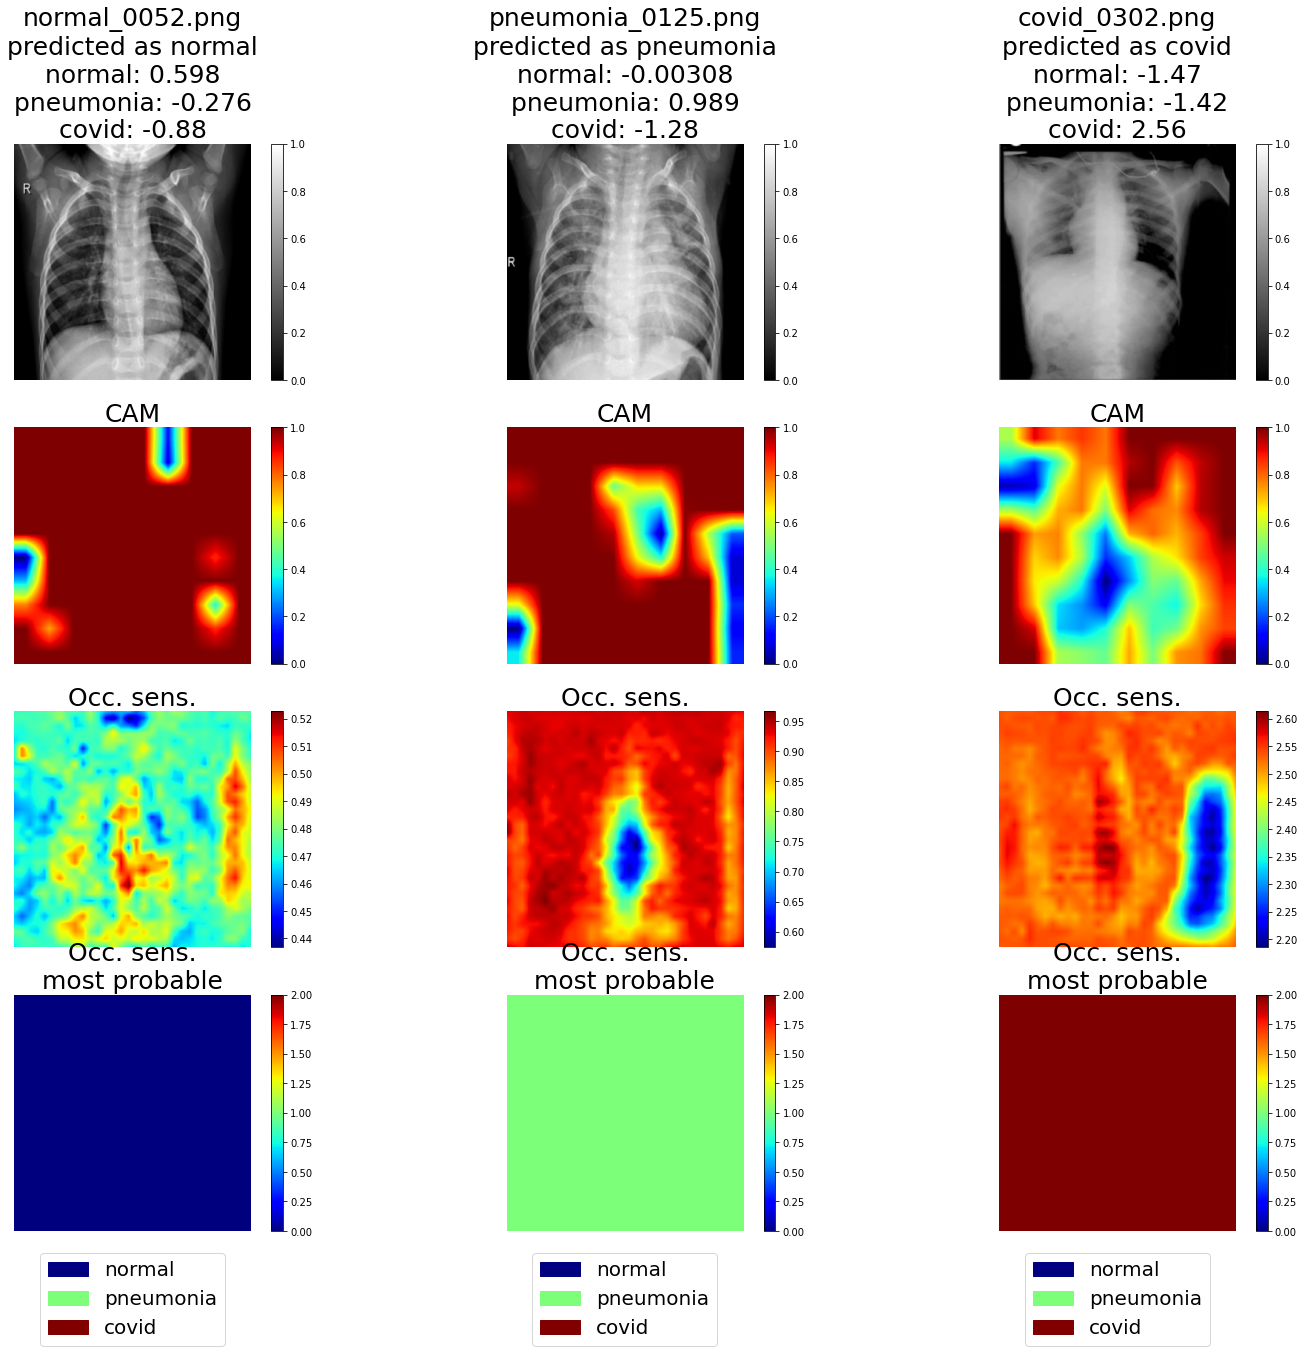

In [11]:
# Display examples
subplot_shape = [4, num_class]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 20), facecolor='white')

for true_label in Diagnosis:

    fnames = [v for v in val_files if true_label.name in os.path.basename(v)]
    random.shuffle(fnames)
    # Find a correctly predicted example
    for fname in fnames:
        img = val_transforms(fname)[None].to(device)
        y_pred = net(img)
        pred_label = Diagnosis(y_pred.argmax(1).item())
        if pred_label == true_label:
            break
    im_title = f"{os.path.basename(fname)}\npredicted as {pred_label.name}"
    for d in Diagnosis:
        im_title += f"\n{d.name}: {y_pred[0,d.value]:.3}"

    res_cam = gradcam(x=img, class_idx=true_label.value)
    occ_map, occ_most_prob = occ_sens(x=img)
    occ_map = occ_map[..., true_label.value]

    # the rest is for visualisations
    for row, (im, title) in enumerate(zip(
        [img, res_cam, occ_map, occ_most_prob],
        [im_title, "CAM", "Occ. sens.", "Occ. sens.\nmost probable"],
    )):
        cmap = 'gray' if row == 0 else 'jet'
        col = true_label.value
        ax = axes[row, col]
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu()
        if row != 3:
            im_show = ax.imshow(im[0][0], cmap=cmap)
        else:
            im_show = ax.imshow(im[0][0], cmap=cmap,
                                vmin=0, vmax=num_class - 1)
            # for the most probable, need to give the classes in the legend
            handles = [mpatches.Patch(
                color=im_show.cmap(im_show.norm(d.value)), label=d.name)
                for d in Diagnosis]
            ax.legend(handles=handles, loc='upper center',
                      bbox_to_anchor=(0.5, -0.05), fontsize=20)

        ax.set_title(title, fontsize=25)
        ax.axis('off')
        fig.colorbar(im_show, ax=ax)